# 프로젝트: 고양이 수염 스티커 만들기

In [1]:
import os
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
import dlib
print ("준비 완료😎")

준비 완료😎


## 01. 데이터 가져오기

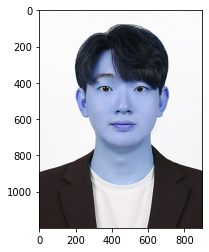

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/증명사진.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

스머프가 한 명 생겼습니다.  
너무 무서워하지 마세요 김도현 맞습니다.  
아.. 원래 무섭게 생겼다고요? 음.. 할 말이 없네요  
이 작업은 얼굴 부분을 인식해서 색을 칠한 작업입니다!

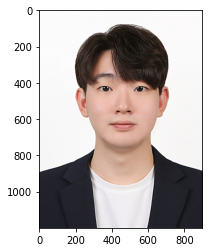

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 02. 얼굴 검출 & 랜드마크 검출 하기

In [4]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해서 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(247, 333) (632, 718)]]


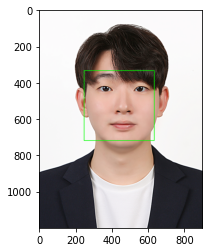

In [5]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

# 사진 출력
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

이 부분은 얼굴을 인식하는 부분입니다.

In [6]:
#  landmark 모델을 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 얼굴의 landmark list들
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark model 확인 얼굴이 하나밖에 없기에 가장 앞에있는 것 확인
print(len(list_landmarks[0]))

68


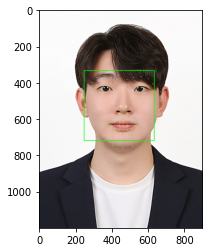

In [7]:
for landmark in list_landmarks:
    for point in landmark:
        # landmark마다 노란색 원을 찍어본다.
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

# 사진 출력
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

자세히 보시면 네모 박스 안에 노란색 원이 찍혀있습니다.  
위에서 설정했는데 잘 나와 주었네요

## 0.3 스티커 확인 하기

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):

    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (461,574)
(w,h) : (386,386)


(386, 386, 3)


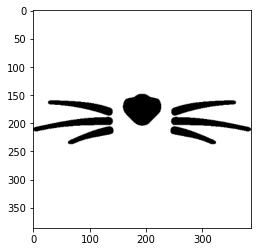

In [9]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

In [10]:
# lefttop 이동
refined_x = x - w // 2
refined_y = y - h // 2

# 범위 넘어서는 곳 자르기
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0


print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (268,381)


## 0.4 스티커 적용하기

In [11]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

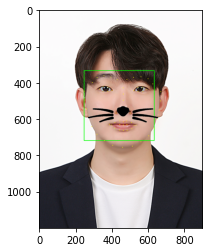

In [12]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

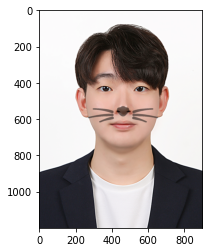

In [13]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# addd weight 조정하여 투명도 조절 
add = cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.3, 0)

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,add).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 0.5 다양한 실험을 위해 함수 만들기

In [14]:
def 내가_만듦(img_path):
    global w,h,x,y
    my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/' + img_path
    img_bgr = cv2.imread(my_image_path)    
    img_show = img_bgr.copy()      
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    detector_hog = dlib.get_frontal_face_detector()

    dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)

    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    for landmark in list_landmarks:
        for point in landmark:
            # landmark마다 노란색 원을 찍어본다.
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)

        x = landmark[33][0]
        y = landmark[33][1]
        w = h = dlib_rect.width()

    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
    img_sticker = cv2.resize(img_sticker, (w,h))

    refined_x = x - w // 2
    refined_y = y - h // 2

    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    add = cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.3, 0)

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,add).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

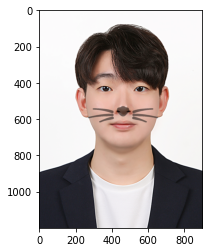

In [15]:
내가_만듦('증명사진.jpg')

증명사진에서 제가 만든 함수가 잘 작동되는지 확인 해 보았습니다.
다행히 잘 실행이 되었네요!

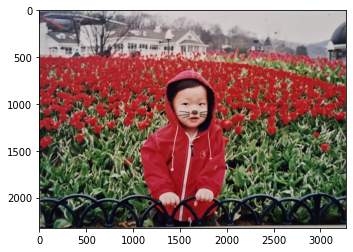

In [16]:
내가_만듦('남춘식_어릴떄.jpg')

다음은 제가 어렸을 적 사진입니다. 멀리서 찍은 사진이고 유아 사진인데도 당연히 잘 작동이 됩니다.

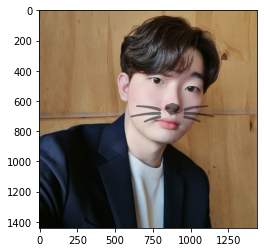

In [17]:
내가_만듦('셀카.jpg')

살짝 기울어진 사진입니다.  
다행히 잘 적용이 되네요  
  하지만 콧수염은 알아서 돌아가 주지 않습니다.

## 회고 

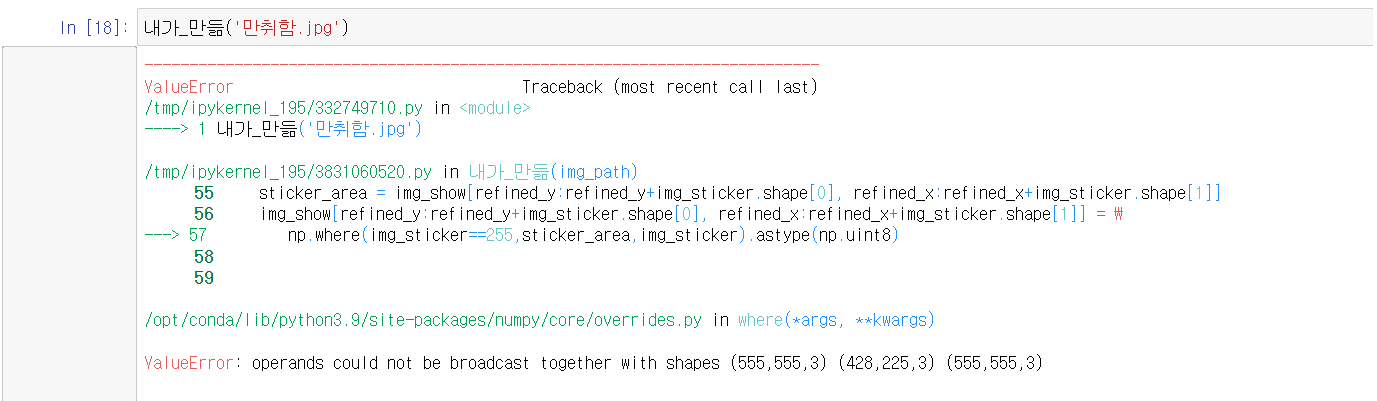
이 그림은 끝내 해결하지 못한 저의 슬픔이 담겨있는 사진입니다.  
무슨 소리인지 이해가 안 가시죠?   제가 차근차근 설명드리겠습니다.  

우선 저 오류의 내용을 봅시가.  
"operands could not be broadcast together with shapes" 라고 적혀 있습니다.
우리가 넘파이를 사용 할 때 넘파이에는 브로드캐스팅이 있습니다.  
파이썬 넘파이에서 말하는 브로드 캐스팅은 __일정 조건을 부합하는 다른 형태의 배열끼리 연산을 수행하는 것을 의미__합니다.
  
  자! 보면 operands could not be broadcast together with shapes 이 뜻은 친절하게 차원이 맞지 않다고 말해줍니다.  
사진이 차원이 안 맞다..? 무슨 의미일까요   
저 에러가 무엇을 의미하는지에 대해서 찾아보고 공부를 해보았을 때 확실히 이해는 됐습니다.
하지만 이것이 왜 사진을 하는 부분에서 진행이 안되는지에 대해서는 이해가 되지 않기 때문에 이것에 대해서 피드백 조심스럽게 부탁드려봅니다.